# Building a Dual Ibor Curve

The aim is to construct an IBOR curve that uses OIS discounting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *

####################################################################
#    FINANCEPY Version 1.1 - This build: 27 Aug 2025 at 23:27      #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [3]:
set_date_format(DateFormatTypes.UK_LONGEST)

In [4]:
value_dt = Date(18, 9, 2019)

## Building the Discount Curve

This is based on OIS rates. We anchor the short end using the overnight rate.

In [5]:
onRate = 0.045

depo_dcc_type = DayCountTypes.THIRTY_E_360_ISDA
depos = []
spot_days = 2
settle_dt = value_dt.add_weekdays(spot_days)
depo = IborDeposit(settle_dt, "1D", onRate, depo_dcc_type); depos.append(depo)

In [6]:
settle_dt

FRI 20 SEP 2019

We use swaps with a regular term

In [7]:
oiss = []
swap_type = SwapTypes.PAY
fixed_dcc_type = DayCountTypes.ACT_365F
fixed_freq_type = FrequencyTypes.SEMI_ANNUAL

swap = OIS(settle_dt, "1Y", swap_type, onRate + 0.0001, fixed_freq_type, fixed_dcc_type); oiss.append(swap)
swap = OIS(settle_dt, "2Y", swap_type, onRate + 0.0003, fixed_freq_type, fixed_dcc_type); oiss.append(swap)
swap = OIS(settle_dt, "3Y", swap_type, onRate + 0.0010, fixed_freq_type, fixed_dcc_type); oiss.append(swap)
swap = OIS(settle_dt, "4Y", swap_type, onRate + 0.0015, fixed_freq_type, fixed_dcc_type); oiss.append(swap)
swap = OIS(settle_dt, "5Y", swap_type, onRate + 0.0020, fixed_freq_type, fixed_dcc_type); oiss.append(swap)
swap = OIS(settle_dt, "7Y", swap_type, onRate + 0.0030, fixed_freq_type, fixed_dcc_type); oiss.append(swap)
swap = OIS(settle_dt, "10Y", swap_type, onRate + 0.0035, fixed_freq_type, fixed_dcc_type); oiss.append(swap)

In [8]:
ois_curve = OISCurve(value_dt, depos, [], oiss, InterpTypes.FLAT_FWD_RATES)

Inserting synthetic deposit


Let's just check a repricing by looking at the value of the longest OIS.

In [9]:
for swap in oiss:
    v_single = swap.value(value_dt, ois_curve) / swap.fixed_leg.notional
    print("%12s  %15.12f" % (swap.maturity_dt, v_single))

MON 21 SEP 2020   0.000000000000
MON 20 SEP 2021  -0.000000000000
TUE 20 SEP 2022   0.000000000000
WED 20 SEP 2023  -0.000000000000
FRI 20 SEP 2024  -0.000000000000
MON 21 SEP 2026  -0.000000000000
THU 20 SEP 2029  -0.000000000001


This is effectively zero. So they are all repriced.

## Building the 3M IBOR Curve

We use ON rate, 3M Ibor FRAs and IBOR swaps with a 3M floating Leg (this is the default for IborSwap)

In [10]:
depo_dcc_type = DayCountTypes.THIRTY_E_360_ISDA
depos = []
depo = IborDeposit(settle_dt, "1D", onRate, depo_dcc_type); depos.append(depo)

pay_fixed = True
fras = []

# 1 x 4 FRA
fra_rate = onRate + 0.0003
fraSettlementDate = settle_dt.add_months(1)
fraMaturityDate = settle_dt.add_months(4)
fra = IborFRA(fraSettlementDate, fraMaturityDate, fra_rate, depo_dcc_type)
fras.append(fra)

# 2 x 5 FRA
fra_rate = onRate + 0.0005
fraSettlementDate = settle_dt.add_months(2)
fraMaturityDate = settle_dt.add_months(5)
fra = IborFRA(fraSettlementDate, fraMaturityDate, fra_rate, depo_dcc_type)
fras.append(fra)

# 3 x 6 FRA
fra_rate = onRate + 0.0007
fraSettlementDate = settle_dt.add_months(3)
fraMaturityDate = settle_dt.add_months(6)
fra = IborFRA(fraSettlementDate, fraMaturityDate, fra_rate, depo_dcc_type)
fras.append(fra)

# 4 x 7 FRA
fra_rate = onRate + 0.0007
fraSettlementDate = settle_dt.add_months(4)
fraMaturityDate = settle_dt.add_months(7)
fra = IborFRA(fraSettlementDate, fraMaturityDate, fra_rate, depo_dcc_type)
fras.append(fra)

# 5 x 8 FRA
fra_rate = onRate + 0.0008
fraSettlementDate = settle_dt.add_months(5)
fraMaturityDate = settle_dt.add_months(8)
fra = IborFRA(fraSettlementDate, fraMaturityDate, fra_rate, depo_dcc_type)
fras.append(fra)

swaps = []
swap_type = SwapTypes.PAY
fixed_dcc_type = DayCountTypes.ACT_365F
fixed_freq_type = FrequencyTypes.SEMI_ANNUAL

swap = IborSwap(settle_dt, "1Y", swap_type, 0.0470, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = IborSwap(settle_dt, "3Y", swap_type, 0.0475, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = IborSwap(settle_dt, "5Y", swap_type, 0.0490, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = IborSwap(settle_dt, "7Y", swap_type, 0.0510, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = IborSwap(settle_dt, "10Y", swap_type, 0.0520, fixed_freq_type, fixed_dcc_type); swaps.append(swap)

Let's first build a single curve that assumes index and funding rates are same

Note that for ease of comparison I use flat forward interpolation

In [11]:
depos[0]

OBJECT TYPE: IborDeposit
START DATE: FRI 20 SEP 2019
MATURITY DATE: MON 23 SEP 2019
NOTIONAL: 100.0
DEPOSIT RATE: 0.045
DAY COUNT TYPE: DayCountTypes.THIRTY_E_360_ISDA
CALENDAR: CalendarTypes.WEEKEND
BUS DAY ADJUST TYPE: BusDayAdjustTypes.MODIFIED_FOLLOWING

In [12]:
ibor_single_curve = IborSingleCurve(value_dt, depos, fras, swaps, InterpTypes.FLAT_FWD_RATES)

Let's check repricing of FRAs and Swaps

In [13]:
for fra in fras:
    v = fra.value(value_dt, ibor_single_curve)/ fra.notional
    print("%12s %18.12f" % (fra.maturity_dt, v))

MON 20 JAN 2020     0.000000000000
THU 20 FEB 2020     0.000000000000
FRI 20 MAR 2020     0.000000000001
MON 20 APR 2020     0.000000000001
WED 20 MAY 2020     0.000000000003


In [14]:
for swap in swaps:
    v = swap.value(value_dt, ibor_single_curve)/ swap.fixed_leg.notional
    print("%12s %18.12f" %(swap.maturity_dt, v))

MON 21 SEP 2020    -0.000000000039
TUE 20 SEP 2022    -0.000000000000
FRI 20 SEP 2024    -0.000000000000
MON 21 SEP 2026    -0.000000000000
THU 20 SEP 2029    -0.000000000003


The fit looks perfect

## Building the Dual Curve

Let's build a dual curve that incorporates funding and index curve differential.

In [15]:
ibor_dual_curve = IborDualCurve(value_dt, ois_curve, depos, fras, swaps, InterpTypes.FLAT_FWD_RATES)

In [16]:
for fra in fras:
    v_dual = fra.value(value_dt, ois_curve, ibor_dual_curve) / fra.notional
    print("%12s %18.12f"% (fra.maturity_dt, v_dual))

MON 20 JAN 2020    -0.000000000000
THU 20 FEB 2020     0.000000000001
FRI 20 MAR 2020     0.000000000001
MON 20 APR 2020     0.000000000001
WED 20 MAY 2020     0.000000000001


In [17]:
for swap in swaps:
    v_dual = swap.value(value_dt, ois_curve, ibor_dual_curve) / swap.fixed_leg.notional
    print("%12s %18.12f"% (swap.maturity_dt, v_dual))

MON 21 SEP 2020     0.000000000000
TUE 20 SEP 2022     0.000000000000
FRI 20 SEP 2024     0.000000000000
MON 21 SEP 2026    -0.000000000000
THU 20 SEP 2029    -0.000000000000


This is within the allowed tolerance.

## Comparison of Curves

We examine the forward rates of the three curves

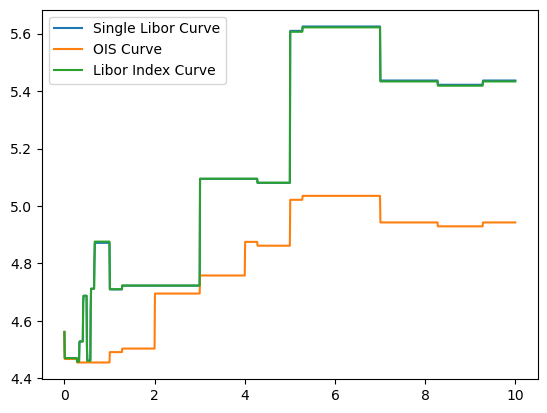

In [18]:
years = np.linspace(0, 10, 1201)
dates = settle_dt.add_years(years)

singleCurveFwds = ibor_single_curve.fwd(dates)
plt.plot(years, singleCurveFwds*100, label="Single Libor Curve")

oisCurveFwds = ois_curve.fwd(dates)
plt.plot(years, oisCurveFwds*100.0, label="OIS Curve")

index_curveFwds = ibor_dual_curve.fwd(dates)
plt.plot(years, index_curveFwds*100.0, label="Libor Index Curve")

plt.legend();

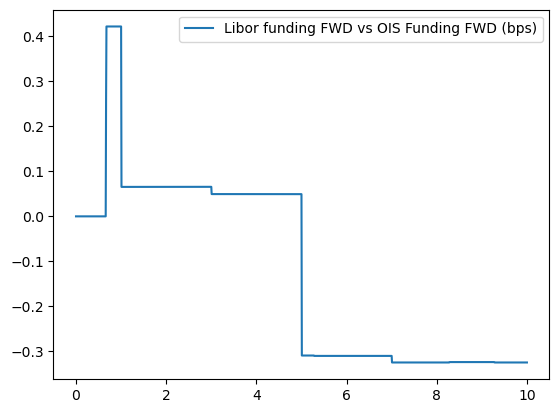

In [19]:
diff = (index_curveFwds - singleCurveFwds)*10000
plt.plot(years, diff, label="Libor funding FWD vs OIS Funding FWD (bps)")
plt.legend()

The difference is small but not negligible.

Copyright (c) Dominic O'Kane 2020